In [1]:
import h5py
import ast
from astropy.table import QTable, Table, Column, vstack
import astropy.units as u
import astropy
%matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import simsurvey
import simsurvey_tools as sst
import matplotlib.pylab as plt
import pandas as pd
import os
from ZTF_hdf5 import Write_LightCurve, Read_LightCurve, Plot_LightCurve

In [2]:
home_dir = os.environ.get('HOME')
sfd98_dir = os.path.join(home_dir, 'data/sfd98')
sfd98_dir = '/Users/manon/ZTF/data/sfd98'

fields = sst.load_ztf_fields()
#sst.load_ztf_filters()
ccds = sst.load_ztf_ccds(filename='data/ZTF_corners_rcid.txt', num_segs=64) #it's rcid
#ccds = sst.load_ztf_ccds() #its' ccd

obs = pd.read_csv('data/2018_all_logs_from_dr1_rcid_zp_from_masci.csv')
obs[obs['rcid']==26]
obs['field'] =obs['field'].astype('int64')
obs['time'] = obs['time'] - 2400000.5

plan = simsurvey.SurveyPlan(time=obs['time'], band=obs['band'], zp=obs['zp'], obs_field=obs['field'], obs_ccd=obs['rcid'],
                            skynoise=obs['skynoise'], fields={k: v for k, v in fields.items() if k in 
                            ['ra', 'dec', 'field_id', 'width', 'height']}, ccds=ccds)

z_range = (0.01, 0.1)
dec_range = (-30, 90)
mjd_range = (plan.cadence['time'].min()- 30, plan.cadence['time'].max() + 30) #
# we  put a ra range as well
ntransient = 11 # we can change the number of transientor the rate (by def  ntransient = len(redshifts))
seed = 70 #we can fix teh seed

tr = simsurvey.get_transient_generator(zrange=z_range, transient='Ia', template='salt2', dec_range=dec_range,
                                       mjd_range=mjd_range, sfd98_dir=sfd98_dir, ntransient=ntransient, seed=seed)

n_det = 10
survey = simsurvey.SimulSurvey(generator=tr, plan=plan, n_det=n_det)

lc_sn_default = survey.get_lightcurves(progress_bar=True, notebook=True) #simullc_func
print(len(lc_sn_default.lcs))

Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)


5


In [3]:
clas = Write_LightCurve()
data = clas.write_data('Data', lc_sn_default)
meta = clas.write_meta()
meta

lc is not an astropy.table.table.Table type <class 'simsurvey.simulsurvey.LightcurveCollection'>
OrderedDict([('directory', '/Users/manon/dataLC/Meta.hdf5'), ('file_name', 'Meta.dhf5')])


In [4]:
clas2 = Read_LightCurve(file_name='Data.hdf5')
read_data = clas2.Read_file(path='SN_1')
read_data

time,band,flux,fluxerr,zp,zpsys,field,ccd,comment
float64,str4,float64,float64,float64,str2,int64,int64,str1
58198.41731479997,ztfr,-21.484466827564876,20.46585984561505,26.325,ab,430,7,
58198.459409699775,ztfr,-29.642261075747708,19.90810834703056,26.325,ab,430,7,
58203.343877300154,ztfg,-137.56552247158902,144.22149583657995,26.275,ab,430,7,
58203.35707180016,ztfg,-37.73515961802923,97.95576387368912,26.275,ab,430,7,
58206.44896990014,ztfg,9.880168958831122,40.46038357356532,26.275,ab,430,7,
58206.459571800195,ztfg,31.748663153896356,37.58633633606533,26.275,ab,430,7,
58209.46320600016,ztfg,-100.67833433828997,135.21659507839638,26.275,ab,430,7,
58216.42704859981,ztfr,5.646108647685638,86.1187934369195,26.325,ab,430,7,
58219.44331019977,ztfr,66.6688685870572,77.55303466817442,26.325,ab,430,7,


In [5]:
import csv
from astropy.table import Table
home_dir = os.environ.get('HOME')
folder_dir = os.path.join(home_dir, 'dataLC/Selection_tab.csv')
print(folder_dir)
folder_dir2 = os.path.join(home_dir, 'dataLC/str_tab.csv')

table = Table.read(folder_dir) #Lecture du fichier csv
table_str = Table.read(folder_dir2) #Lecture du fichier csv

/Users/manon/dataLC/Selection_tab.csv


In [6]:
table

col,lim_col,op1,seuil,name_selec
str5,int64,str11,int64,str12
phase,0,operator.le,4,nb_phase<0
phase,0,operator.ge,10,nb_phase>0
phase,-10,operator.le,1,nb_phase<-10
phase,20,operator.ge,1,nb_phase>20


In [7]:
import operator
def selec_phase(Tab, csvFile, Verbose=False):
    
    if csvFile['col'] not in Tab.colnames:
        print('This column doesnt exist') 
    
    else:
        col = csvFile['col']
        op = eval(csvFile['op1'])
        lim = csvFile['lim_col']
    
        mask = op(Tab[col], lim)
        Tab = Tab[mask]
    
    if Verbose:
        print('len Tab :', len(Tab))
    
    return len(Tab)

In [8]:
def selec(Tab, csvFile, limSNR, Verbose=False,  Plot=False, selec=False):
    
    SNR = Tab['flux'] / Tab['fluxerr']
    phase = (Tab['time'] - Tab.meta['t0']) / (1-Tab.meta['z'])
    Tab.add_columns([SNR, phase], names=['SNR', 'phase'])
    mask_SNR = Tab['SNR'] >= limSNR
    Tab = Tab[mask_SNR]
    res = 1
    
    
    if Verbose:
        print('min :', np.min(Tab['phase']), 'max :', np.max(Tab['phase']))
    if Plot:
        x = Tab['phase']
        y = Tab['flux']

        fig, axs = plt.subplots(1, 1, figsize=(10,8))
        axs.plot(x,y,marker = '*')
    
    if not selec :
        selec = []    
        for i, row in enumerate(csvFile):
            len_tab = selec_phase(Tab, row)
            if res:
                res &= operator.ge(len_tab, row['seuil'])
                selec.append(row['name_selec'])
            if not res:
                break
        return selec, res
    else:
        return Tab

In [9]:
class_meta = Read_LightCurve(file_name='Meta.hdf5')
read_meta = class_meta.Read_file(path='meta')

csvTab = table
rtot = []
rb = csvTab['name_selec']   
for i, row in enumerate(read_meta):
    Tab = selec(lc_sn_default[i], csvTab, 5, selec=True)
    r = []
    for i, rowb in enumerate(csvTab):
        nb = selec_phase(Tab, rowb)
        r.append(nb)
    rtot.append(r)

rtot = np.array(rtot)
#print(rtot, len(rtot))

for i in range(0,len(rtot[0])):
    line = [row[i] for row in rtot]
    c = Column(line)
    read_meta.add_column(c, name=rb[i])
read_meta

z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path,nb_phase<0,nb_phase>0,nb_phase<-10,nb_phase>20
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str4,int64,int64,int64,int64
0.09545085017442173,58371.817850549065,0.0002771357912699138,-0.62548765619564,0.08991019018243052,0.144720279260781,352.06966274388003,44.524529678477535,0.14370772544891622,1,SN_0,14,29,2,1
0.052395678566137256,58231.201247162135,0.0011922258089010543,-2.6676509956069445,-0.03448578174354965,0.2748790046966661,242.8963714073767,-5.72510622133645,0.2746621642499891,5,SN_1,3,11,1,4
0.07527202479792483,58421.5335325382,0.0005445907219979513,-0.2915194225651692,0.09710010223419693,0.028955382485282188,122.88362397997601,72.3087518839699,0.021226937444662287,7,SN_2,0,144,0,64
0.07864194667329098,58210.721340815704,0.0008432786739296758,-0.1441809256096224,-0.07964318534293403,0.028054051979465203,175.80441899319186,2.7920990514452346,0.017430438951182806,8,SN_3,6,11,0,6
0.07636610797218073,58273.41723662111,0.0004897470345753179,-0.9579709291843637,0.07850842542752962,0.027115198698569112,190.470983126126,13.051813235586533,0.023295795365418693,9,SN_4,14,48,2,9


In [10]:
R, sel_list = [], []

for i, path in enumerate(read_meta['path']):
    class_data = Read_LightCurve(file_name='Data.hdf5')
    lc = class_data.Read_file(path=path)
    sel = selec(lc, csvTab, limSNR=5, Verbose=False, Plot=False)
    R.append(sel[1])
    sel_list.append(list(sel[0]))
    #print(path, sel)
    
pass_selec = Column(R)
read_meta.add_column(pass_selec, name = 'pass selec')
read_meta

z,t0,x0,x1,c,mwebv,ra,dec,mwebv_sfd98,idx_orig,path,nb_phase<0,nb_phase>0,nb_phase<-10,nb_phase>20,pass selec
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str4,int64,int64,int64,int64,int64
0.09545085017442173,58371.817850549065,0.0002771357912699138,-0.62548765619564,0.08991019018243052,0.144720279260781,352.06966274388003,44.524529678477535,0.14370772544891622,1,SN_0,14,29,2,1,1
0.052395678566137256,58231.201247162135,0.0011922258089010543,-2.6676509956069445,-0.03448578174354965,0.2748790046966661,242.8963714073767,-5.72510622133645,0.2746621642499891,5,SN_1,3,11,1,4,0
0.07527202479792483,58421.5335325382,0.0005445907219979513,-0.2915194225651692,0.09710010223419693,0.028955382485282188,122.88362397997601,72.3087518839699,0.021226937444662287,7,SN_2,0,144,0,64,0
0.07864194667329098,58210.721340815704,0.0008432786739296758,-0.1441809256096224,-0.07964318534293403,0.028054051979465203,175.80441899319186,2.7920990514452346,0.017430438951182806,8,SN_3,6,11,0,6,0
0.07636610797218073,58273.41723662111,0.0004897470345753179,-0.9579709291843637,0.07850842542752962,0.027115198698569112,190.470983126126,13.051813235586533,0.023295795365418693,9,SN_4,14,48,2,9,1


In [11]:
mask_pass_selec = read_meta['pass selec'] == 1
read_meta_test = read_meta[mask_pass_selec]

data = Read_LightCurve(file_name='Data.hdf5')
lc = data.Read_file(path='SN_0')

SN_0
Number of chi^2 function calls: 438
Number of degrees of freedom in fit: 91
chi^2 value at minimum: 143.09877595607801
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 6.25171328e-01  5.83776069e+04  1.25018826e-04  2.12025119e-01
 -3.64409730e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])
Errors corresponding to the different fitting parameters:
 OrderedDict([('z', 0.009165347381172029), ('t0', 0.24618665988600696), ('x0', 2.615045839690736e-06), ('x1', 0.14716940847407164), ('c', 0.006466827833404327)])
result.success: 
 True
result.message: 
 Minimization exited successfully.
result.vparam_names: 
 ['z', 't0', 'x0', 'x1', 'c']
Matrice de covariance : 
 [[ 8.41004416e-05  1.28991022e-03 -1.24733252e-08  5.92174690e-04
   6.42263796e-06]
 [ 1.28991022e-03  6.06080060e-02 -1.85249732e-07  1.42850237e-02
   4.419

<IPython.core.display.Javascript object>


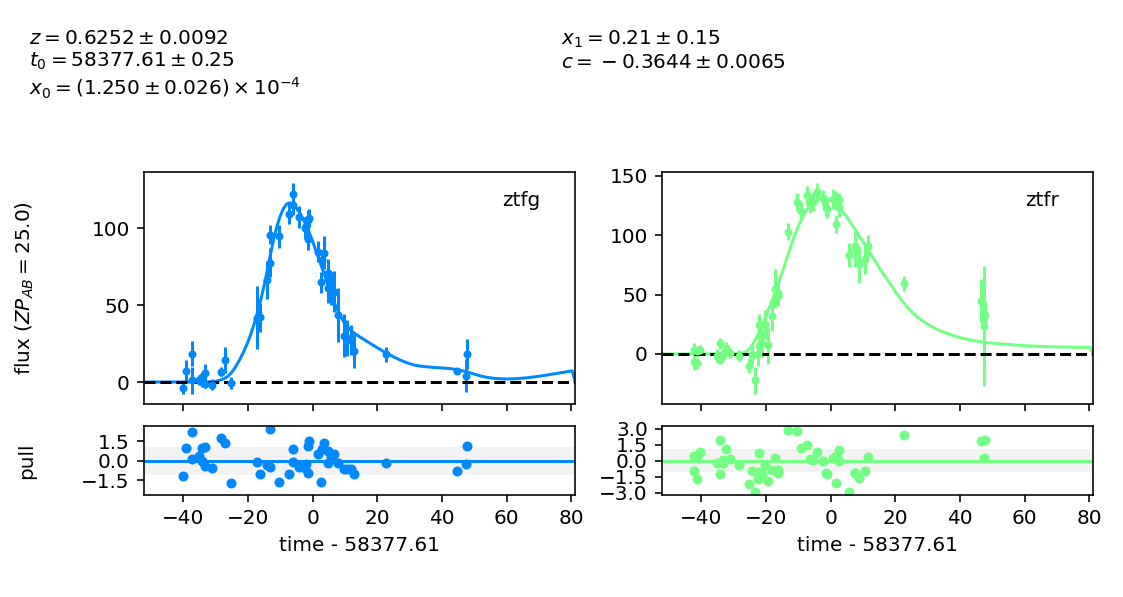

SN_4
Number of chi^2 function calls: 231
Number of degrees of freedom in fit: 110
chi^2 value at minimum: 282.6864336498836
model parameters: ['z', 't0', 'x0', 'x1', 'c']
best-fit values: [ 3.00000000e-01  5.82748559e+04  4.30604436e-04 -1.36972640e+00
 -2.58711982e-01]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])
Errors corresponding to the different fitting parameters:
 OrderedDict([('z', 0.0008519137668913379), ('t0', 0.1412457075966813), ('x0', 4.120007377479233e-06), ('x1', 0.11952068629447402), ('c', 0.00920640758494123)])
result.success: 
 True
result.message: 
 Minimization exited successfully.
result.vparam_names: 
 ['z', 't0', 'x0', 'x1', 'c']
Matrice de covariance : 
 [[ 3.58959564e-18 -1.75594650e-13  3.66801513e-18 -1.83995566e-14
   1.22067227e-14]
 [-1.75594650e-13  1.99503649e-02 -3.57792490e-07  9.04646114e-03
   3.7066

<IPython.core.display.Javascript object>


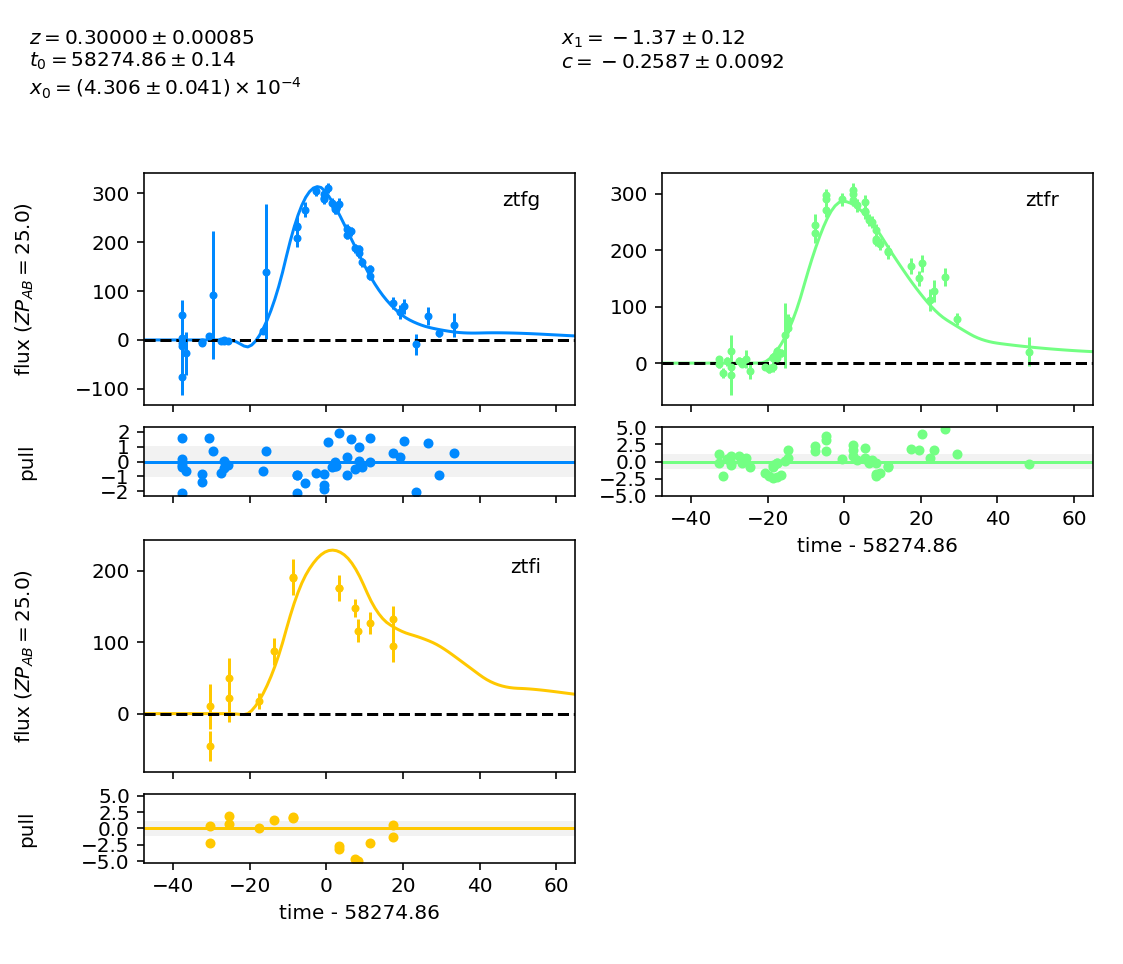

In [12]:
import sncosmo
import iminuit
import colorama
from colorama import Fore
from colorama import Style

mask_pass_selec = read_meta['pass selec'] == 1
read_meta_test = read_meta[mask_pass_selec]

for i, row in enumerate(read_meta_test):
    path = row['path']
    print(path)
    data = Read_LightCurve(file_name='Data.hdf5')
    lc = data.Read_file(path=path)
    #str_tab = lc.read('/Users/manon/dataLC/Data.hdf5', character_as_bytes=False, path=path)
    
    # create a model
    model = sncosmo.Model(source='salt2')

    # run the fit
    try:
        result, fitted_model = sncosmo.fit_lc(
            lc, model,
            ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
            bounds={'z':(0.3, 0.7)})  # bounds on parameters (if any)
    
        print("Number of chi^2 function calls:", result.ncall)
        print("Number of degrees of freedom in fit:", result.ndof)
        print("chi^2 value at minimum:", result.chisq)
        print("model parameters:", result.param_names)
        print("best-fit values:", result.parameters)
        print("The result contains the following attributes:\n", result.keys())
        print("Errors corresponding to the different fitting parameters:\n", result.errors)
        print('result.success: \n', result.success)
        print('result.message: \n', result.message)
        print('result.vparam_names: \n', result.vparam_names)
        print('Matrice de covariance : \n', result.covariance)
        print('result.nfit: \n', result.nfit)
        print('result.data_mask: \n', result.data_mask)
    
        sncosmo.plot_lc(lc, model=fitted_model, errors=result.errors)
        
    except:
        print("WARNING : That was no valid light curve.")